In [19]:
# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [20]:
from utils import convert_episodes_to_traj_class, nodes2cell
import evaluation_metrics as em
from decision_bias_analysis_tools import ComputeFourBiasClips2
from parameters import EXPLORE, HOME_NODE
import utils

In [3]:
# Some lists of nicknames for mice
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [33]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.size"] = 18

In [5]:
figpath = '/Users/us3519/mouse-maze/figs/poster figures'

In [329]:
from matplotlib.collections import LineCollection

def plt_trajectory(state_hist_all, episode_idx, save_file_name=None, title=None, display=True, figsize=(9,9), entry_exit_colorbar=False):
    '''
    Plots specified simulated trajectories on the maze layout.
    
    state_hist_all: list of trajectories simulated by a model.
        Eg. [[0,1,3..], [28, 57, 116, ..], [0, 2, ..]]
    episode_idx: 'all', to plot all trajectories in state_hist_all
             int, to plot a specific bout/episode with index episode_idx
    
    Plots One maze figure with plotted trajectories and a color bar indicating nodes from entry to exit
    Returns: None
    '''
    state_hist_cell, state_hist_xy = nodes2cell(state_hist_all)
    
#     print(state_hist_cell[0][:4], state_hist_cell[0][-10:])
#     print(state_hist_xy[0][-10:])
    
    ma=NewMaze(6)
    # Draw the maze outline    
    fig,ax=plt.subplots(figsize=figsize)
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=2,yflip=True,
              xhide=True,yhide=True,axes=ax, title=None, alpha=1)

    re=[[-0.5,0.5,1,1],[-0.5,4.5,1,1],[-0.5,8.5,1,1],[-0.5,12.5,1,1],
       [2.5,13.5,1,1],[6.5,13.5,1,1],[10.5,13.5,1,1],
       [13.5,12.5,1,1],[13.5,8.5,1,1],[13.5,4.5,1,1],[13.5,0.5,1,1],
       [10.5,-0.5,1,1],[6.5,-0.5,1,1],[2.5,-0.5,1,1],
       [6.5,1.5,1,1],[6.5,11.5,1,1],[10.5,5.5,1,1],[10.5,7.5,1,1],
       [5.5,4.5,1,1],[5.5,8.5,1,1],[7.5,4.5,1,1],[7.5,8.5,1,1],[2.5,5.5,1,1],[2.5,7.5,1,1],
       [-0.5,2.5,3,1],[-0.5,10.5,3,1],[11.5,10.5,3,1],[11.5,2.5,3,1],[5.5,0.5,3,1],[5.5,12.5,3,1],
       [7.5,6.5,7,1]]  # coordinates of gray rectangles, the inaccessible regions of the maze

    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray', alpha=0.6)
        ax.add_patch(rect)
    plt.axis('off')

    for id, epi in enumerate(state_hist_xy):
        x = epi[:,0]
        y = epi[:,1]
        t = np.linspace(0,1,x.shape[0]) # your "time" variable

        # set up a list of (x,y) points
        points = np.array([x,y]).transpose().reshape(-1,1,2)

        # set up a list of segments
        segs = np.concatenate([points[:-1],points[1:]],axis=1)

        # make the collection of segments
        lc = LineCollection(segs, cmap=plt.get_cmap('viridis'),linewidths=5) # jet, viridis hot
        lc.set_array(t) # color the segments by our parameter

#         # put a blue star in the beginning and a yellow star in the end of each trajectory
#         plt.plot(points[ 0, 0, 0], points[ 0, 0, 1], "*", markersize=10, color="blue")
#         plt.plot(points[-1, 0, 0], points[-1, 0, 1], "*", markersize=10, color="yellow")

        # plot the collection
        lines=ax.add_collection(lc); # add the collection to the plot

    # entry-exit colorbar
    if entry_exit_colorbar:
        cax=fig.add_axes([1.05, 0.05, 0.05, 0.9])
        cbar=fig.colorbar(lines,cax=cax)
        cbar.set_ticks([0,1])
        cbar.set_ticklabels(['Entry','Exit'])
        cbar.ax.tick_params(labelsize=30)

#     fig.suptitle(figtitle, fontsize=14)
    ax.set_title(title, y=0.99, fontsize=50)
    plt.tight_layout()
    fig = plt.gcf()
    if save_file_name:
        fig.savefig(save_file_name, dpi=300)
    if display:
        plt.show()
    return

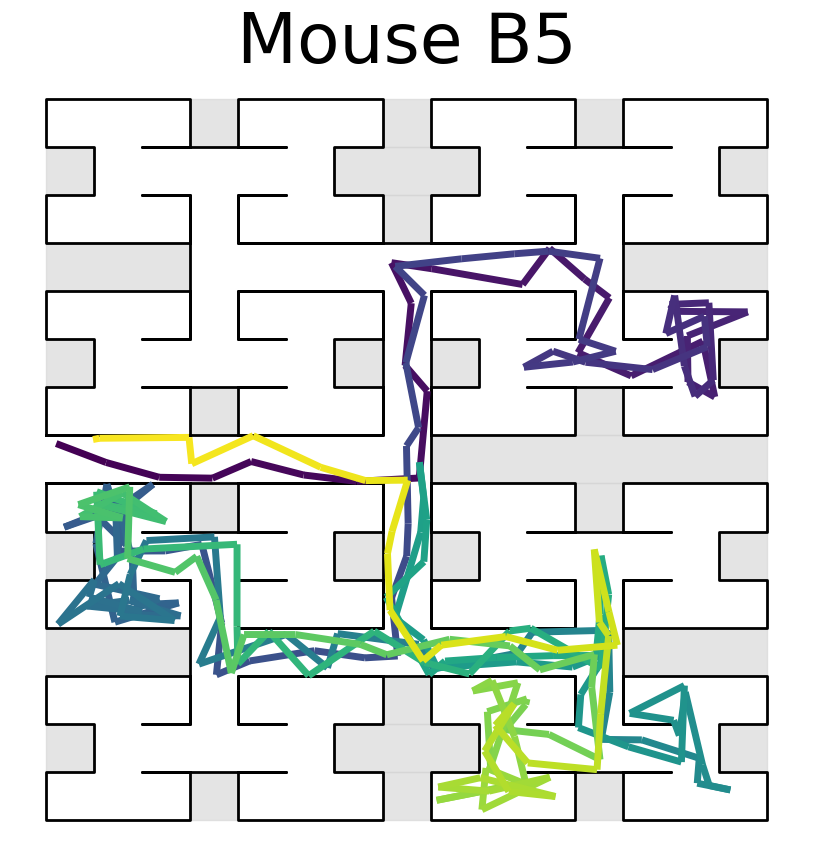

In [333]:
tf = LoadTrajFromPath('../outdata/B5-tf')
i = np.random.choice(len(tf.no))
# print(i)

i=81

traj = tf.no[i][:, 0]
plt_trajectory([traj], 'all',
                save_file_name=f'{figpath}/mouseb5_poster.pdf',
#                 display=False, 
               title=f'Mouse B5'
              )
    
# for i in range(1, len(tf.no)):
#     print(i)
#     traj = tf.no[i][:, 0]
#     plt_trajectory([traj], 'all',
# #                     save_file_name=f'{figpath}/mouseb5_poster.png',
#     #                 display=False, 
#                    title=f'Mouse B5'
#                   )
#     if i >= 100:
#         break

In [7]:
# simulation923050, trajectory 4 to plot

ezgreedy = "/Users/us3519/mouse-maze/figs/LWISOptL6Alternate/simulation923050/episodes.pkl"

with open(os.path.join(ezgreedy), 'rb') as f:
    ezgreedy_stats = pickle.load(f)

ezgreedy_tf = convert_episodes_to_traj_class(ezgreedy_stats["episodes_positions"], ezgreedy_stats["episodes_states"])

In [254]:
[(i, len(ezgreedy_stats['episodes_positions'][i])) for i in range(len(ezgreedy_stats['episodes_positions']))]

[(0, 12),
 (1, 4),
 (2, 10),
 (3, 26),
 (4, 114),
 (5, 120),
 (6, 8),
 (7, 6),
 (8, 126),
 (9, 12),
 (10, 6),
 (11, 84),
 (12, 56),
 (13, 4),
 (14, 30),
 (15, 52),
 (16, 84),
 (17, 54),
 (18, 36),
 (19, 14),
 (20, 14),
 (21, 4),
 (22, 24),
 (23, 6),
 (24, 14),
 (25, 28),
 (26, 22),
 (27, 44),
 (28, 100),
 (29, 12),
 (30, 4),
 (31, 64),
 (32, 6),
 (33, 38),
 (34, 54),
 (35, 6),
 (36, 122),
 (37, 90),
 (38, 36),
 (39, 28),
 (40, 26),
 (41, 74),
 (42, 68),
 (43, 22),
 (44, 4),
 (45, 10),
 (46, 26),
 (47, 84),
 (48, 30),
 (49, 54),
 (50, 54),
 (51, 82),
 (52, 16),
 (53, 48),
 (54, 28),
 (55, 16),
 (56, 108),
 (57, 70),
 (58, 4),
 (59, 44),
 (60, 76),
 (61, 10),
 (62, 6),
 (63, 30),
 (64, 38),
 (65, 24),
 (66, 10),
 (67, 86),
 (68, 14),
 (69, 18),
 (70, 4),
 (71, 24),
 (72, 34),
 (73, 4),
 (74, 8),
 (75, 30),
 (76, 72),
 (77, 26),
 (78, 6),
 (79, 74),
 (80, 30),
 (81, 6),
 (82, 44),
 (83, 92),
 (84, 4),
 (85, 10),
 (86, 26),
 (87, 4),
 (88, 140),
 (89, 52),
 (90, 6),
 (91, 14),
 (92, 14),
 

4 100


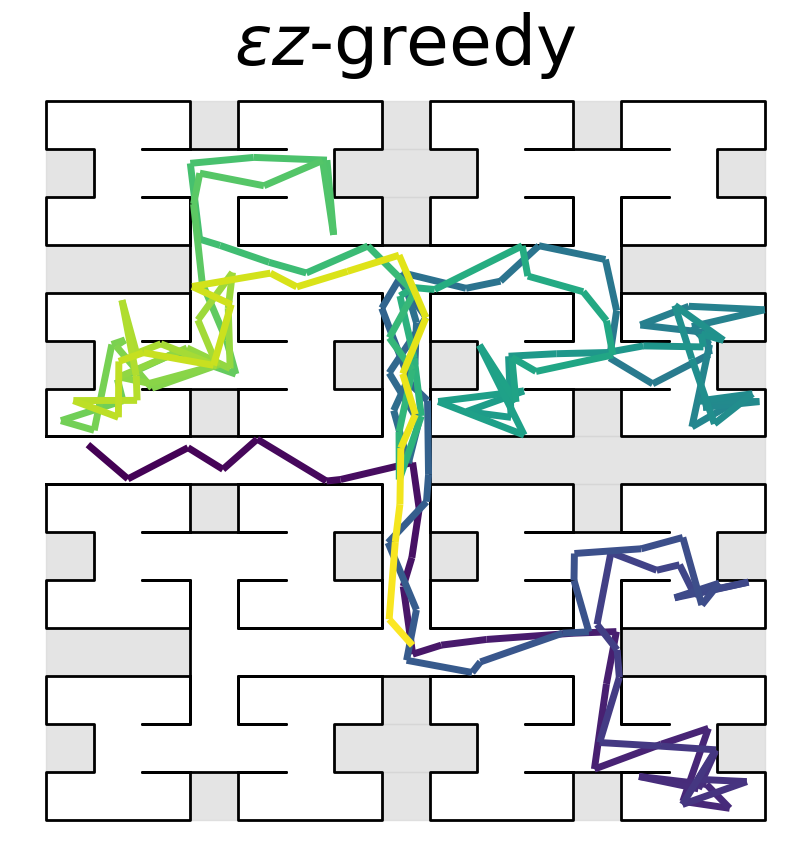

In [255]:
# i = np.random.choice(len(ezgreedy_stats['episodes_positions']))
i = 4

traj = ezgreedy_stats['episodes_positions'][i][:100]
print(i, len(traj))
plt_trajectory([traj], 'all',
#                 save_file_name=f'{figpath}/ezgreedybehaviortraj_poster.png',
#                 display=False, 
               title=f'$\epsilon z$-greedy'
              )

In [10]:
len(ezgreedy_tf.no)

859

In [11]:
ucb = "/Users/us3519/mouse-maze/figs/TD_UCBpolicy/simulation232946/episodes.pkl"

with open(os.path.join(ucb), 'rb') as f:
    ucb_stats = pickle.load(f)

ucb_tf = convert_episodes_to_traj_class(ucb_stats["episodes_positions"], ucb_stats["episodes_states"])

In [12]:
[(i, len(b)) for i, b in enumerate(ucb_stats['episodes_positions'])]

[(0, 182),
 (1, 278),
 (2, 398),
 (3, 366),
 (4, 454),
 (5, 730),
 (6, 802),
 (7, 940),
 (8, 1564),
 (9, 1886),
 (10, 2426),
 (11, 2674),
 (12, 4062),
 (13, 2971)]

366


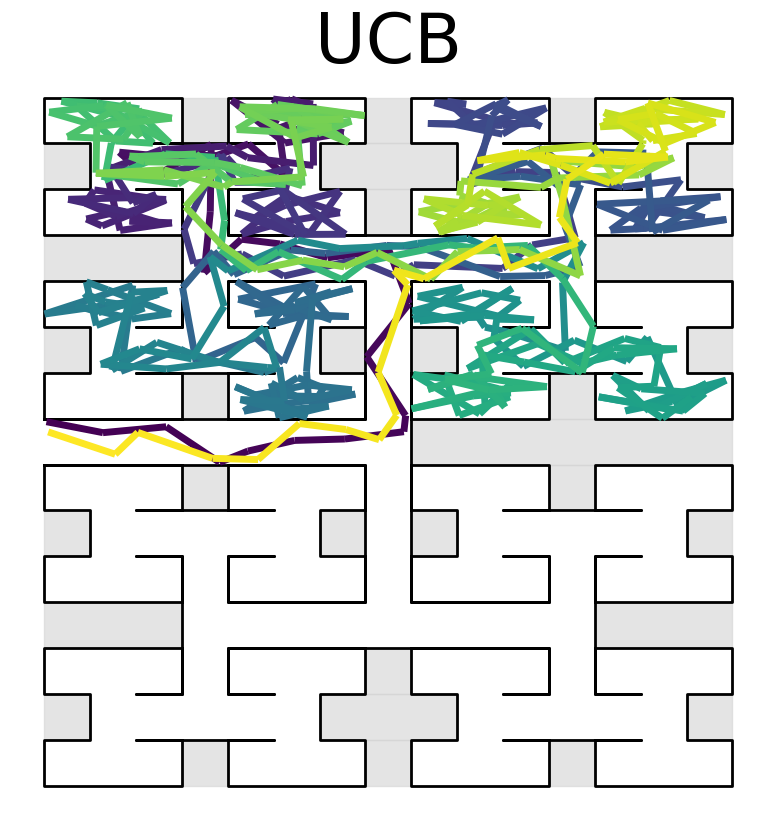

In [13]:
traj = ucb_stats['episodes_positions'][3]
print(len(traj))
plt_trajectory([traj], 'all', display=False, title=f'UCB',
               save_file_name=f'{figpath}/ucbtraj.pdf'
              )

In [14]:
len(ucb_tf.no)

14

In [15]:
bayesian = "/Users/us3519/mouse-maze/figs/BayesianQL/simulation3998/episodes.pkl"

with open(os.path.join(bayesian), 'rb') as f:
    bayesian_stats = pickle.load(f)

bayesian_tf = convert_episodes_to_traj_class(bayesian_stats["episodes_positions"], bayesian_stats["episodes_states"])

In [16]:
[(i, len(b)) for i, b in enumerate(bayesian_stats['episodes_positions'])]

[(0, 1),
 (1, 12),
 (2, 14),
 (3, 18),
 (4, 58),
 (5, 220),
 (6, 236),
 (7, 436),
 (8, 324),
 (9, 284),
 (10, 266),
 (11, 300),
 (12, 278),
 (13, 274),
 (14, 282),
 (15, 338),
 (16, 290),
 (17, 254),
 (18, 254),
 (19, 288),
 (20, 266),
 (21, 258),
 (22, 290),
 (23, 276),
 (24, 262),
 (25, 250),
 (26, 270),
 (27, 318),
 (28, 258),
 (29, 256),
 (30, 260),
 (31, 254),
 (32, 256),
 (33, 274),
 (34, 260),
 (35, 260),
 (36, 268),
 (37, 254),
 (38, 266),
 (39, 256),
 (40, 302),
 (41, 254),
 (42, 246),
 (43, 346),
 (44, 288),
 (45, 264),
 (46, 296),
 (47, 270),
 (48, 260),
 (49, 260),
 (50, 274),
 (51, 254),
 (52, 288),
 (53, 256),
 (54, 260),
 (55, 316),
 (56, 254),
 (57, 288),
 (58, 254),
 (59, 278),
 (60, 270),
 (61, 254),
 (62, 256),
 (63, 282),
 (64, 254),
 (65, 268),
 (66, 262),
 (67, 262),
 (68, 260),
 (69, 268),
 (70, 256),
 (71, 260),
 (72, 260),
 (73, 286),
 (74, 254),
 (75, 286),
 (76, 260),
 (77, 254),
 (78, 4)]

236


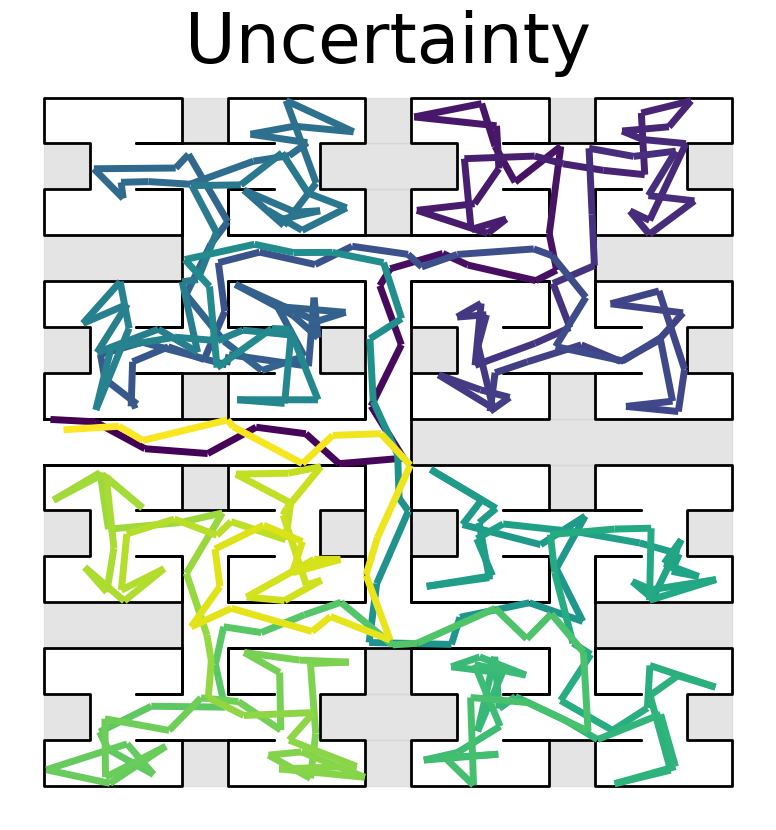

In [17]:
traj = bayesian_stats['episodes_positions'][6]
print(len(traj))
plt_trajectory([traj], 'all', display=False, title=f'Uncertainty',
               save_file_name=f'{figpath}/bayesiantraj.pdf'
              )

In [18]:
random_tf=LoadTrajFromPath('../outdata/rw01-tf')

In [19]:
len(random_tf.no)

408

In [20]:
[(i, len(b)) for i, b in enumerate(random_tf.no)]

[(0, 6),
 (1, 2),
 (2, 2),
 (3, 1418),
 (4, 48),
 (5, 4),
 (6, 66),
 (7, 6),
 (8, 838),
 (9, 200),
 (10, 104),
 (11, 112),
 (12, 8),
 (13, 14),
 (14, 4),
 (15, 18),
 (16, 2),
 (17, 540),
 (18, 2),
 (19, 974),
 (20, 2),
 (21, 98),
 (22, 578),
 (23, 1410),
 (24, 1282),
 (25, 384),
 (26, 2),
 (27, 2),
 (28, 48),
 (29, 2),
 (30, 410),
 (31, 2),
 (32, 142),
 (33, 14),
 (34, 352),
 (35, 2),
 (36, 2),
 (37, 1136),
 (38, 1170),
 (39, 1342),
 (40, 2),
 (41, 556),
 (42, 172),
 (43, 2),
 (44, 338),
 (45, 1066),
 (46, 2),
 (47, 2),
 (48, 40),
 (49, 2),
 (50, 8),
 (51, 2),
 (52, 2),
 (53, 62),
 (54, 736),
 (55, 2),
 (56, 2),
 (57, 412),
 (58, 4),
 (59, 2),
 (60, 2),
 (61, 6),
 (62, 34),
 (63, 2),
 (64, 158),
 (65, 2),
 (66, 544),
 (67, 792),
 (68, 68),
 (69, 2),
 (70, 458),
 (71, 1218),
 (72, 8),
 (73, 8),
 (74, 2),
 (75, 2),
 (76, 8),
 (77, 496),
 (78, 282),
 (79, 442),
 (80, 2),
 (81, 732),
 (82, 2),
 (83, 766),
 (84, 234),
 (85, 2),
 (86, 182),
 (87, 42),
 (88, 6),
 (89, 2),
 (90, 2),
 (91, 2),


158


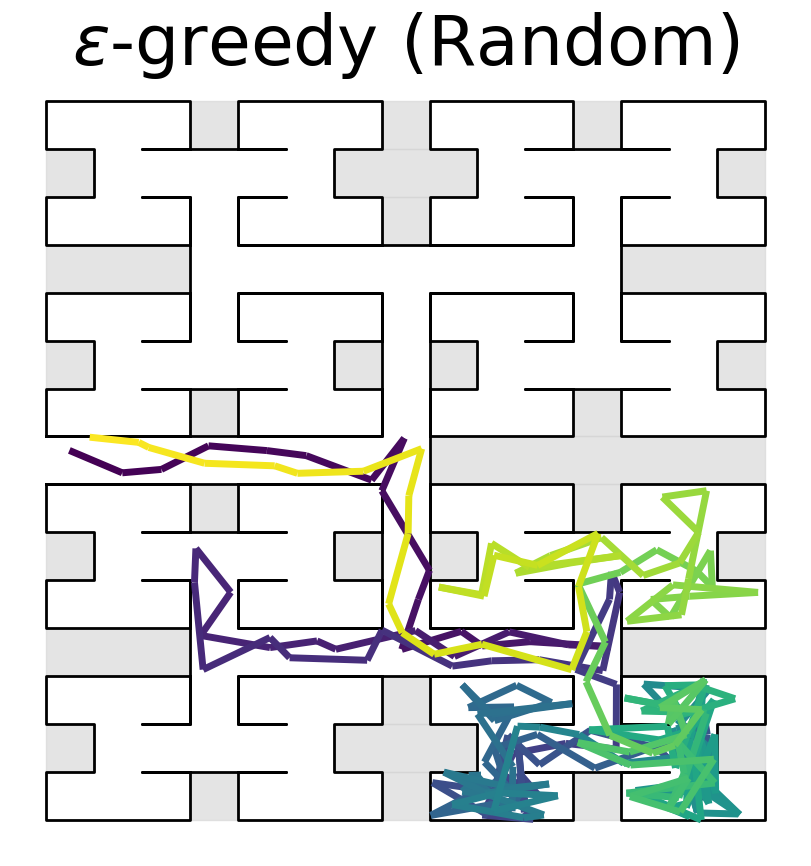

In [331]:
traj = random_tf.no[64][:, 0][:300]
print(len(traj))
plt_trajectory([traj], 'all', display=False, title=f'$\epsilon$-greedy (Random)',
               save_file_name=f'{figpath}/randomwalktraj.pdf'
              )

In [22]:
biasedwalk_tf=LoadTrajFromPath('../outdata/B7-RW5-tf')
len(biasedwalk_tf.no)

3077

In [23]:
[(i, len(b)) for i, b in enumerate(biasedwalk_tf.no)]

[(0, 2),
 (1, 4),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 2),
 (6, 2),
 (7, 214),
 (8, 2),
 (9, 154),
 (10, 16),
 (11, 36),
 (12, 2),
 (13, 174),
 (14, 6),
 (15, 48),
 (16, 10),
 (17, 180),
 (18, 2),
 (19, 2),
 (20, 2),
 (21, 36),
 (22, 58),
 (23, 16),
 (24, 2),
 (25, 4),
 (26, 2),
 (27, 2),
 (28, 88),
 (29, 382),
 (30, 2),
 (31, 30),
 (32, 16),
 (33, 2),
 (34, 2),
 (35, 74),
 (36, 404),
 (37, 32),
 (38, 40),
 (39, 50),
 (40, 8),
 (41, 2),
 (42, 2),
 (43, 4),
 (44, 2),
 (45, 2),
 (46, 6),
 (47, 94),
 (48, 2),
 (49, 16),
 (50, 2),
 (51, 2),
 (52, 2),
 (53, 62),
 (54, 120),
 (55, 2),
 (56, 2),
 (57, 2),
 (58, 2),
 (59, 20),
 (60, 26),
 (61, 4),
 (62, 58),
 (63, 2),
 (64, 2),
 (65, 2),
 (66, 2),
 (67, 6),
 (68, 26),
 (69, 38),
 (70, 2),
 (71, 2),
 (72, 12),
 (73, 2),
 (74, 2),
 (75, 2),
 (76, 2),
 (77, 8),
 (78, 2),
 (79, 22),
 (80, 2),
 (81, 2),
 (82, 2),
 (83, 74),
 (84, 2),
 (85, 2),
 (86, 4),
 (87, 98),
 (88, 4),
 (89, 122),
 (90, 2),
 (91, 8),
 (92, 72),
 (93, 2),
 (94, 2),
 (95, 2),
 (96, 2

2474 178


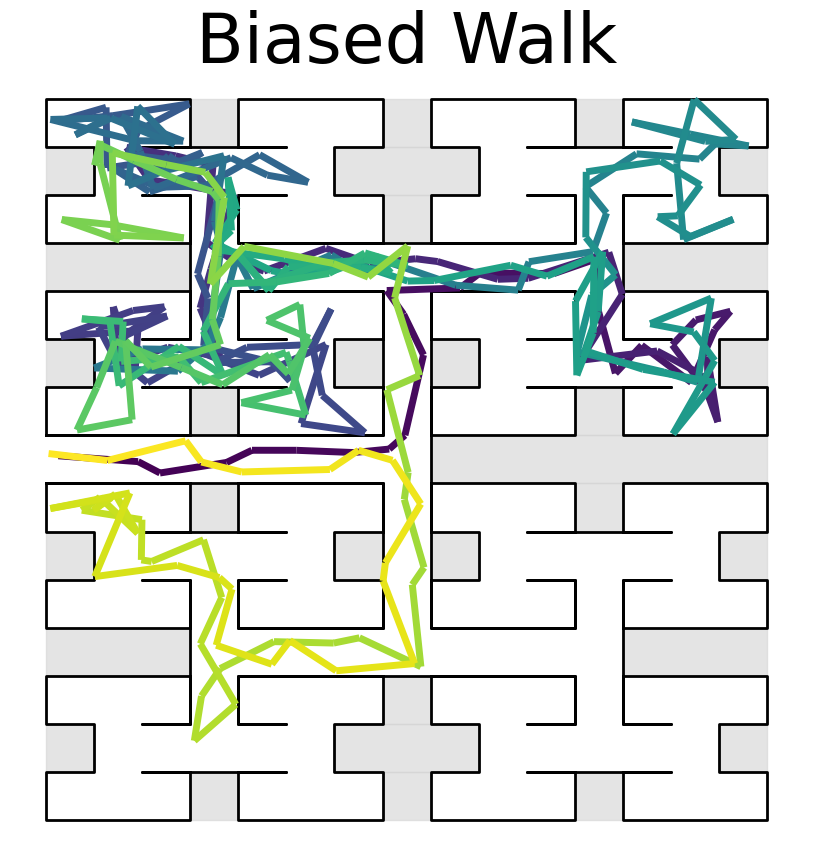

In [408]:
i = np.random.choice(len(biasedwalk_tf.no))
traj = biasedwalk_tf.no[i][:, 0]
print(i, len(traj))
plt_trajectory([traj], 'all', display=False, title=f'Biased Walk',
#                save_file_name=f'{figpath}/biasedwalktraj.pdf'
              )

In [1283]:
ezgreedy_tfs = []
for f in glob.glob('/Users/us3519/mouse-maze/figs/LWISOptL6Alternate/simulations/*.pkl'):
    s = joblib.load(f)
    tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
    ezgreedy_tfs.append(tf)

In [1175]:
bw_tfs = []
for f in glob.glob('/Users/us3519/mouse-maze/figs/BiasedWalk4/MAX_LENGTH=35000/**/episodes_*.pkl'):
    s = joblib.load(f)
    tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
    bw_tfs.append(tf)
len(bw_tfs)

12

In [1116]:
unc_tfs = []
for f in glob.glob('/Users/us3519/mouse-maze/figs/Optimal/MAX_LENGTH=10000/**/episodes_*.pkl'):
    s = joblib.load(f)
    tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
    unc_tfs.append(tf)
len(unc_tfs)

3

In [1123]:
markov_tfs = []
for nickname in UnrewNamesSub:
    tf = joblib.load(f'/Users/us3519/mouse-maze/Rosenberg-2021-Repository/outdata/{nickname}-MarkovSim-tf')
#     tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
    markov_tfs.append(tf)
len(markov_tfs)

9

In [25]:
import glob, joblib

In [1284]:
ma=NewMaze()
le = 6

(14,) (14,)
(14,) (14,)
(13,) (13,)
(13,) (13,)
(14,) (14,)
(15,) (15,)
(15,) (15,)
(14,) (14,)
(14,) (14,)
(13,)
(13,)


/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_1489/806277549.py:111: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x32a744550> starts with '_'. It is thus excluded from the legend.
  plt.legend(legends, loc='upper left', fontsize=18)
/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_1489/806277549.py:111: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x328d15850> starts with '_'. It is thus excluded from the legend.
  plt.legend(legends, loc='upper left', fontsize=18)
/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_1489/806277549.py:111: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x316f44430> starts with '_'. It is thus excluded from the legend.
  plt.legend(legends, loc='upper left', fontsize=18)


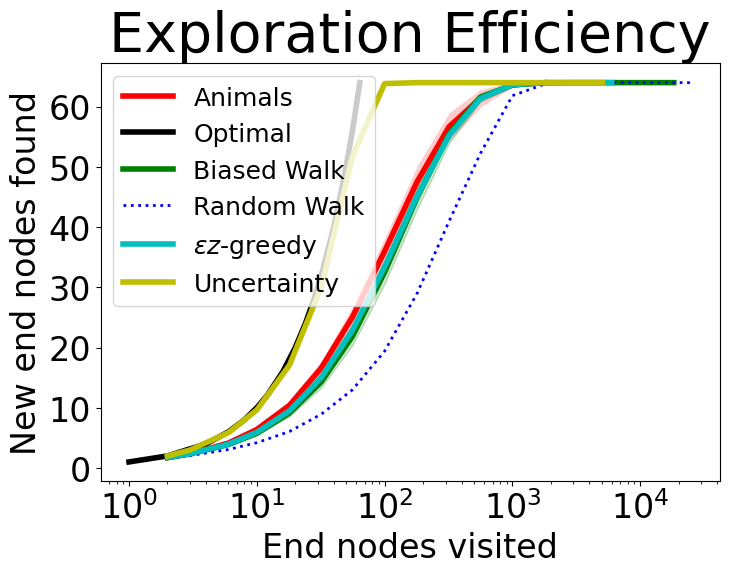

In [1339]:
legends = []
linewidth = 4

# an animal
y_animal = []
min_len = np.inf
for nickname in UnrewNamesSub:
    with open('../outdata/'+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn=pickle.load(f)
    x=wcn[1,:]
    y=wcn[2,:]
    print(x.shape, y.shape)
    y_animal.append(y)
    min_len = min(min_len, len(y))

y_animal = [y[:min_len] for y in y_animal]

x = x[:min_len]
y_animal_mean = np.mean(np.array(y_animal), axis=0)
y_std = np.std(np.array(y_animal), axis=0)
print(x.shape)
print(y_animal_mean.shape)
ax=plot(x,y_animal_mean,figsize=(7, 5),fmts=['r-'],linewidth=linewidth)
legends.append('Animals')
ax.fill_between(x, y_animal_mean+y_std, y_animal_mean-y_std, color="r", alpha=0.2, linewidth=0);
legends.append('_')

# DFS
x_dfs=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64],
y_dfs=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64], 
plot(x_dfs,y_dfs,fmts=['k-'],axes=ax,linewidth=linewidth);
legends.append('Optimal')

# biased random walk
ybrw_animal = []
min_len = np.inf
for nickname in UnrewNamesSub:
    tf=LoadTrajFromPath('../outdata/'+nickname+'-RW5-tf')
    wcn=NewNodesMerge3(tf,ma,le)
    xbrw=wcn[1]
    ybrw=wcn[2]
    ybrw_animal.append(ybrw)
    min_len = min(min_len, len(ybrw))
xbrw = xbrw[:min_len]
ybrw_animal = [y[:min_len] for y in ybrw_animal]
ybrw = np.mean(np.array(ybrw_animal), axis=0)
ybrw_std = np.std(np.array(ybrw_animal), axis=0)
plot(xbrw, ybrw, fmts=['g-'],linewidth=linewidth,axes=ax)
legends.append('Biased Walk')
ax.fill_between(xbrw, ybrw+ybrw_std, ybrw-ybrw_std, color="g", alpha=0.2);
legends.append('_')

# unbiased random walk
tf=LoadTrajFromPath('../outdata/rw01-tf')
wcn=NewNodesMerge3(tf,ma,le)
x=wcn[1,:]
y=wcn[2,:]
plot(x,y,fmts=['b:'],axes=ax)
legends.append('Random Walk')

# ezgreedy agent
yez_simulations = []
popt_ez = []
min_len = np.inf
for tf in ezgreedy_tfs:
    wcn=NewNodesMerge3(tf,ma,le) 
    xez=wcn[1]
    yez=wcn[2]
    popt, pcov = curve_fit(func, xez, yez, p0=[a,b])
    popt_ez.append(popt[0])
    yez_simulations.append(yez)
    min_len = min(min_len, len(yez))

xez = xez[:min_len]
yez_simulations = [_[:min_len] for _ in yez_simulations]
popt_ez = np.array(popt_ez)
yez = np.mean(np.array(yez_simulations), axis=0)
yez_std = np.std(np.array(yez_simulations), axis=0)
plot(xez, yez, fmts=['c-'],linewidth=linewidth,axes=ax)
legends.append('$\epsilon z$-greedy')
ax.fill_between(yez, yez+yez_std, yez-yez_std, color="c", alpha=0.2);
legends.append('_')

# # ucb agent
# wcn=NewNodesMerge3(ucb_tf,ma,le) 
# xucb=wcn[1]
# yucb=wcn[2]
# plot(xucb, yucb, fmts=['y-'],linewidth=2,axes=ax)
# legends.append('UCB')

# bayesian agent
wcn=NewNodesMerge3(bayesian_tf,ma,le) 
xbayes=wcn[1]
ybayes=wcn[2]
plot(xbayes, ybayes, xscale='log', fmts=['y-'],linewidth=linewidth,axes=ax)
legends.append('Uncertainty')

# x=[1,20000]
# y=[32,32]
# plot(x,y,axes=ax,fmts=['k:'],linewidth=linewidth,
#      xscale='log',
#      xlim=[3,2000],ylim=[0,65],
# #      xticks=[10,100, 1000],
# );

plt.title('Exploration Efficiency', fontsize=40)
plt.xlabel('End nodes visited', fontsize=24)
plt.ylabel('New end nodes found', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(legends, loc='upper left', fontsize=18)
# plt.savefig(f'{figpath}/expeff_le={le}.pdf', bbox_inches='tight')
plt.show()

In [1336]:
with open('../../Rosenberg-2021-Repository/outdata/ExplRWPars2', 'rb') as f: 
    _,W=pickle.load(f) # walks
W[:, 0]

with open('../../Rosenberg-2021-Repository/outdata/'+'ExplPars3', 'rb') as f: 
    _,M,_=pickle.load(f) # mice

In [1324]:
UWa=32/W[k:,0];
UWa

array([0.32083339, 0.33830598, 0.35291856, 0.36880794, 0.35234923,
       0.33094794, 0.32551243, 0.2692979 , 0.2993612 ])

In [1337]:
UMa=32/M[k:,0]
UMa

array([0.43755344, 0.41035536, 0.35198511, 0.39913881, 0.40937474,
       0.41380455, 0.40263129, 0.34925578, 0.3181911 ])

In [1341]:
UEza = 32/popt_ez
UEza

array([0.33053624, 0.33211912, 0.33853611, 0.34159919, 0.33816988,
       0.33836037, 0.34106404, 0.35227825, 0.34935022, 0.34655685,
       0.34946534])

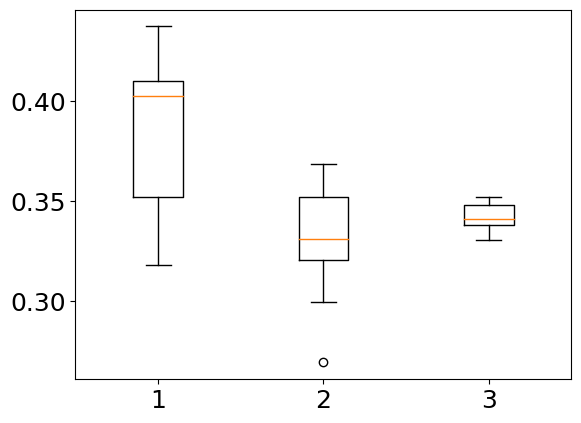

In [1356]:
plt.boxplot([UMa, UWa, UEza])
plt.show()

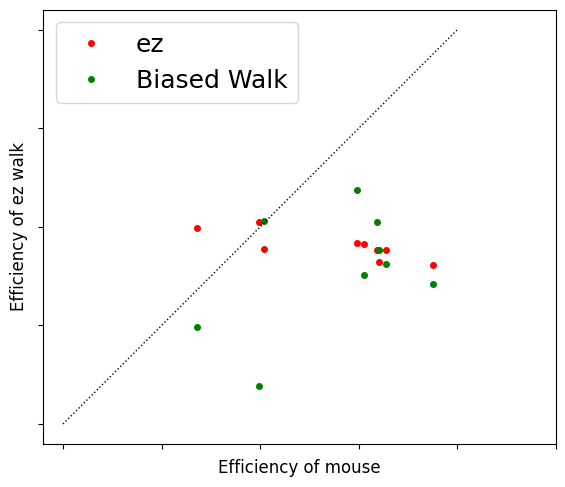

In [1352]:
ax=plot([UMa, UMa], [UEza[:9], UWa], fmts=['r.','g.'],markersize=8,
        xlabel='Efficiency of mouse',ylabel='Efficiency of ez walk',
        equal=True,legend=['ez','Biased Walk'], figsize=(6, 6))

plot([0.25,0.45],[0.25,0.45],fmts=['k:'],linewidth=1,axes=ax,
    xticks=[0.25,0.3,0.35,0.4,0.45,0.5],yticks=[0.25,0.3,0.35,0.4,0.45]);

In [1330]:
def func(x, a, b):
    z=x/a
    return 64*(1-1/(1+(z+b*z**3)/(1+b)))

a=70 # starting value
b=0.1 # starting value

popt, pcov = curve_fit(func, xez, yez, p0=[a,b])

In [1332]:
32/popt[0]

0.3415867620309962

In [1335]:
popt_ez

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [1317]:
ybrw_animal = np.array(ybrw_animal)
ybrw_animal

array([[ 1.78798032,  2.40018847,  3.95224631,  5.79842932,  9.03393025,
        14.09563758, 21.39882698, 31.95287958, 44.71698113, 55.13559322,
        61.79411765, 63.78947368, 63.9       , 64.        , 64.        ,
        64.        , 64.        ],
       [ 1.74966303,  2.36102941,  3.93492647,  5.77573529,  9.30022075,
        14.72745098, 22.42611684, 33.18404908, 45.67777778, 55.88235294,
        61.37931034, 63.75      , 64.        , 64.        , 64.        ,
        64.        , 64.        ],
       [ 1.75704182,  2.37192852,  3.97989576,  5.9255121 ,  9.52178771,
        15.15506958, 23.14285714, 34.39751553, 46.31460674, 56.14      ,
        61.92857143, 63.875     , 64.        , 64.        , 64.        ,
        64.        , 64.        ],
       [ 1.79118943,  2.44240937,  4.12197885,  6.17747011,  9.91043084,
        15.71370968, 24.        , 34.69620253, 47.61363636, 57.73469388,
        62.53571429, 63.8       , 64.        , 64.        , 64.        ,
        64.        

In [50]:
from sklearn.metrics import r2_score

In [51]:
r2_score(y_animal_mean, ybrw[:len(y_animal_mean)])

0.9950788674139154

In [52]:
r2_score(y_animal_mean, yez[:len(y_animal_mean)])

0.9970605841237589

In [53]:
r2_score(y_animal_mean, y_dfs[0][:len(y_animal_mean)])

0.3326071353310832

In [54]:
dict(zip(yez, xez))

{1.7455764523207633: 2.0,
 2.355353826158901: 3.0,
 3.958296807453176: 6.0,
 5.9201112635555075: 10.0,
 9.479057855723369: 18.0,
 15.057854541252581: 32.0,
 22.891539272092267: 56.0,
 33.43328878156818: 100.0,
 45.206399682306944: 180.0,
 55.248039215686276: 320.0,
 61.330000000000005: 560.0,
 63.666666666666664: 1000.0,
 64.0: 5988.0}

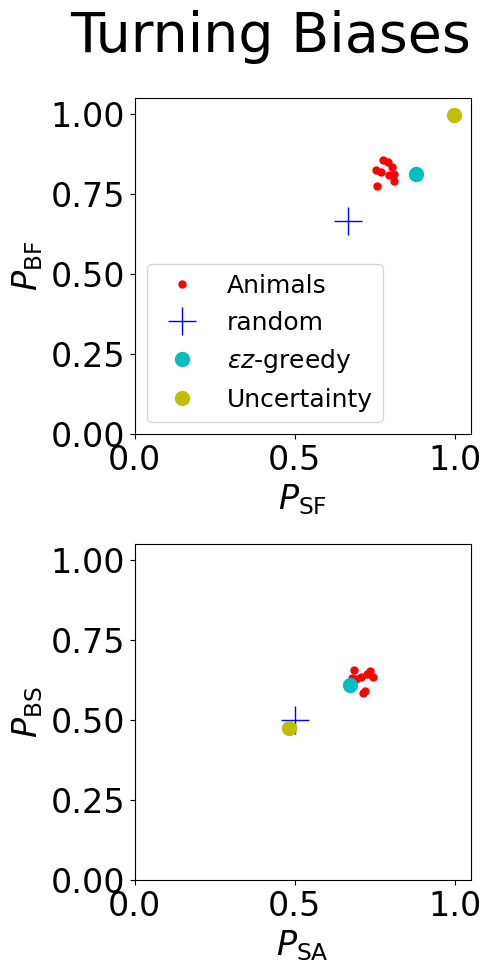

In [143]:
with open('../outdata/ExplBiases', 'rb') as f:
    Names,bi=pickle.load(f)
    

tf=ezgreedy_tf 
cl=SplitModeClips(tf,ma) # find the clips
bi_ez = np.array([ComputeFourBiasClips2(tf,ma,cl,mode=EXPLORE)[0]]) # bias using exploration only


tf=ucb_tf 
cl=SplitModeClips(tf,ma) # find the clips
bi_ucb = np.array([ComputeFourBiasClips2(tf,ma,cl,mode=EXPLORE)[0]]) # bias using exploration only

tf=bayesian_tf 
cl=SplitModeClips(tf,ma) # find the clips
bi_bayesian = np.array([ComputeFourBiasClips2(tf,ma,cl,mode=EXPLORE)[0]]) # bias using exploration only


fig, ax = plt.subplots(2, 1, figsize=(20, 10))

#plot biases BF vs SF
plot([bi[10:,0]],
     [bi[10:,2]],
     fmts=['r.'],markersize=10, alpha=1,
    xlim=[0,1.05],ylim=[0,1.05],equal=True,
    axes=ax[0]);

plot([[2/3], bi_ez[:, 0], bi_bayesian[:, 0]],
     [[2/3], bi_ez[:, 2], bi_bayesian[:, 2]],
     fmts=['b+', 'c.', 'y.'],markersize=20,
    xlim=[0,1.05],ylim=[0,1.05],equal=True,
     legend=['Animals', 'random', '$\epsilon z$-greedy', 'Uncertainty'],
     loc='lower left',
     axes=ax[0]);

ax[0].set_xlabel('$P_{\mathrm{SF}}$', fontsize=24)
ax[0].set_ylabel('$P_{\mathrm{BF}}$', fontsize=24)

#plot biases BS vs SA
plot([bi[10:,1]],
     [bi[10:,3]],
     fmts=['r.'],markersize=10, alpha=1,
    xlim=[0,1.05],ylim=[0,1.05],equal=True,
     axes=ax[1]);

plot([[1/2], bi_ez[:, 1], bi_bayesian[:, 1]],
     [[1/2], bi_ez[:, 3], bi_bayesian[:, 3]],
     fmts=['b+', 'c.', 'y.'],markersize=20,
    xlim=[0,1.05],ylim=[0,1.05],equal=True,
    axes=ax[1]);

ax[1].set_xlabel('$P_{\mathrm{SA}}$', fontsize=24)
ax[1].set_ylabel('$P_{\mathrm{BS}}$', fontsize=24)

for _ in ax:
    _.tick_params(axis='both', labelsize=24)

fig.align_ylabels()
# plt.suptitle('Turning Biases', y=0.778, fontsize=14)
plt.suptitle('Turning Biases', x=0.51, fontsize=40)

plt.tight_layout()
plt.savefig(f'{figpath}/decisionbiases.pdf', dpi=300, bbox_inches='tight')

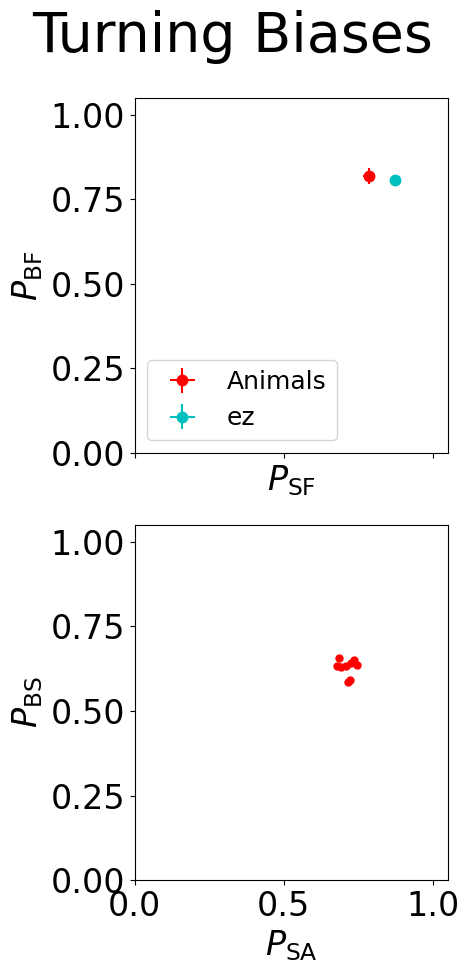

In [141]:
with open('../outdata/ExplBiases', 'rb') as f:
    Names,bi=pickle.load(f)
    

tf=ezgreedy_tf 
cl=SplitModeClips(tf,ma) # find the clips
bi_ez = np.array([ComputeFourBiasClips2(tf,ma,SplitModeClips(tf,ma),mode=EXPLORE)[0] for tf in ezgreedy_tfs]) # bias using exploration only


tf=ucb_tf 
cl=SplitModeClips(tf,ma) # find the clips
bi_ucb = np.array([ComputeFourBiasClips2(tf,ma,cl,mode=EXPLORE)[0]]) # bias using exploration only

tf=bayesian_tf 
cl=SplitModeClips(tf,ma) # find the clips
bi_bayesian = np.array([ComputeFourBiasClips2(tf,ma,cl,mode=EXPLORE)[0]]) # bias using exploration only


fig, ax = plt.subplots(2, 1, figsize=(5, 10), sharex=True, sharey=True)

animals_mean_sf = np.mean(bi[10:,0])
animals_std_sf = 1*np.std(bi[10:,0])
animals_mean_bf = np.mean(bi[10:,2])
animals_std_bf = 1*np.std(bi[10:,2])


ez_mean_sf = np.mean(bi_ez[:,0])
ez_std_sf = 1*np.std(bi_ez[:,0])
ez_mean_bf = np.mean(bi_ez[:,2])
ez_std_bf = 1*np.std(bi_ez[:,2])

# ax[0].plot(bi[10:,0], bi[10:,2], 'r.' ,markersize=10, label='Animals')
ax[0].errorbar(animals_mean_sf, animals_mean_bf, xerr=animals_std_sf, yerr=animals_std_bf, fmt='r.', markersize=15, label='Animals')
ax[0].errorbar(ez_mean_sf, ez_mean_bf, xerr=ez_std_sf, yerr=ez_std_bf, fmt='c.', markersize=15, label='ez')

ax[0].set_xlim([0,1.05])
ax[0].set_ylim([0,1.05])
ax[0].set_xlabel('$P_{\mathrm{SF}}$', fontsize=24)
ax[0].set_ylabel('$P_{\mathrm{BF}}$', fontsize=24)

ax[1].plot(bi[10:,1], bi[10:,3], 'r.' ,markersize=10, label='Animals')
ax[1].set_xlim([0,1.05])
ax[1].set_ylim([0,1.05])
ax[1].set_xlabel('$P_{\mathrm{SA}}$', fontsize=24)
ax[1].set_ylabel('$P_{\mathrm{BS}}$', fontsize=24)

ax[0].legend(loc='lower left', fontsize=18)
for _ in ax:
    _.tick_params(axis='both', labelsize=24)

plt.suptitle('Turning Biases', fontsize=40)
plt.tight_layout()


In [129]:
bi.shape, bi_ez.shape, np.mean(bi_ez[:, 0]), np.std(bi_ez[:, 0])

((19, 4), (10, 4), 0.8724004969166467, 0.005377560014271247)

In [179]:
with open('../outdata/oiratio_unrewarded.pkl', 'rb') as f:
    animal_oiratios = pickle.load(f)

In [180]:
animal_oiratios = list(animal_oiratios.values())
animal_oiratios

[2.232879340111261,
 2.57408668028137,
 2.694080113434953,
 1.7626373626373626,
 1.9241211277410373,
 1.6428820048729553,
 1.8524762908324552,
 2.5424733996162567,
 3.4871794871794872]

In [181]:
# Vuwa_outer, Vuwa_inner = (np.array([0.02721594, 0.01643205, 0.01130046, 0.01626552, 0.01859482,
#         0.01327494, 0.01922983, 0.02806245, 0.01778683, 0.01264062,
#         0.01811219, 0.02573228, 0.0187254 , 0.027018  , 0.038012  ,
#         0.02724372, 0.02485442, 0.01711031, 0.02171151, 0.03393364,
#         0.02157135, 0.01600934, 0.02524051, 0.01757236, 0.01174176,
#         0.01768214]),
#  np.array([0.00598548, 0.00806933, 0.00838761, 0.01173764, 0.01169124,
#         0.00725014, 0.01695927, 0.01211008, 0.00824698, 0.01154421,
#         0.00633527, 0.00836185, 0.01778793, 0.01289504, 0.01366746,
#         0.0088574 ]))

In [182]:
ez_ratios = [em.outside_inside_ratio(tf, re=False) for tf in ezgreedy_tfs]

Agent: Ratio of visits to outer vs inner leaf nodes = 2.476, with entropy = 5.721
Agent: Ratio of visits to outer vs inner leaf nodes = 2.041, with entropy = 5.713
Agent: Ratio of visits to outer vs inner leaf nodes = 2.599, with entropy = 5.698
Agent: Ratio of visits to outer vs inner leaf nodes = 2.350, with entropy = 5.716
Agent: Ratio of visits to outer vs inner leaf nodes = 2.619, with entropy = 5.725
Agent: Ratio of visits to outer vs inner leaf nodes = 2.519, with entropy = 5.743
Agent: Ratio of visits to outer vs inner leaf nodes = 2.392, with entropy = 5.719
Agent: Ratio of visits to outer vs inner leaf nodes = 2.666, with entropy = 5.669
Agent: Ratio of visits to outer vs inner leaf nodes = 2.698, with entropy = 5.650
Agent: Ratio of visits to outer vs inner leaf nodes = 2.421, with entropy = 5.726


In [183]:
with open('../outdata/outside_inside_visits_unrewarded.pkl', 'rb') as f:
    Vuw = pickle.load(f)

In [184]:
inner=np.array([75,76,77,78,87,88,89,90,99,100,101,102,111,112,113,114])-63
outer=np.array([63,65,71,73,95,97,103,105,106,109,110,121,122,125,126,124,94,92,86,84,83,80,79,68,67,64])-63

In [185]:
bw_ratios = [(np.mean(Vuw[i, outer])/np.mean(Vuw[i, inner])) for i in range(len(Vuw))]

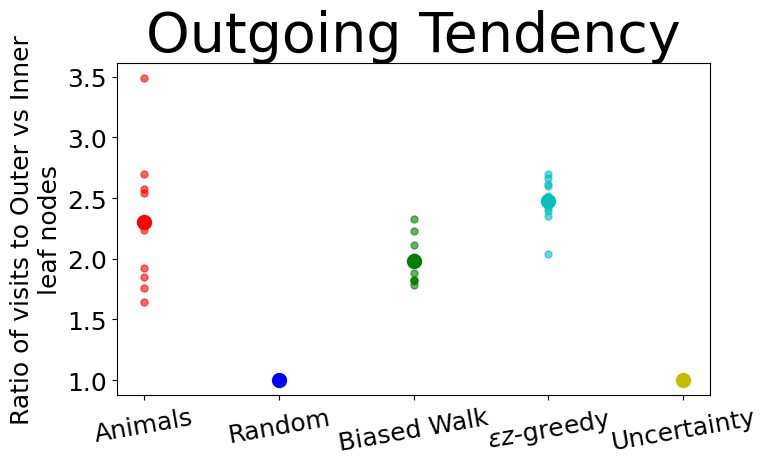

In [212]:
plt.figure(figsize=(8, 5))

data = [animal_oiratios, [1.0], bw_ratios, ez_ratios, [1.0]]
# bplot = plt.boxplot(data, 
#                     patch_artist=True,
#                     widths=0.2,
# #                     boxprops=dict(facecolor='red', color='red', alpha=0.3),
#                     showfliers = True,
# #                     boxprops=dict(alpha=.3)
#                    )


colors = ['r', 'b', 'g', 'c', 'y']
xticks = [1, 2, 3, 4, 5]
for i, d in zip(xticks, data):
#     if isinstance(d, float):
#         plt.plot(i, d, f'{colors[i]}.', markersize=15)
#     else:
    plt.plot([i]*len(d), d, f'{colors[i-1]}.', markersize=10, alpha=0.6)
    plt.plot(i, np.mean(d), f'{colors[i-1]}.', markersize=20, alpha=1)

plt.xticks(xticks, ['Animals', 'Random', 'Biased Walk', '$\epsilon z$-greedy', 'Uncertainty'], fontsize=18, rotation=10)
plt.title('Outgoing Tendency', fontsize=40)
plt.ylabel('Ratio of visits to Outer vs Inner\nleaf nodes', fontsize=18)

# colors = ['pink', 'lightblue', 'lightgreen']
# colors = ['r', 'b', 'g', 'c', 'y']
# for patch, color in zip(bplot['boxes'], colors):
#     patch.set_facecolor(color)
#     patch.set_color(color)
#     patch.set_alpha(0.2)

plt.tight_layout()
plt.savefig(f'{figpath}/oiratio.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [187]:
np.mean(animal_oiratios), np.std(animal_oiratios)

(2.3014239785230157, 0.5542986682281033)

In [188]:
np.mean(bw_ratios), np.std(bw_ratios)

(1.9791910637582193, 0.190321616656911)

In [189]:
np.mean(ez_ratios), np.std(ez_ratios)

(2.4779884302959916, 0.18385622631299492)

[2.232879340111261,
 2.57408668028137,
 2.694080113434953,
 1.7626373626373626,
 1.9241211277410373,
 1.6428820048729553,
 1.8524762908324552,
 2.5424733996162567,
 3.4871794871794872]

In [236]:
# Table of entropies from all methods for TJs and exploration
with open('../../Rosenberg-2021-Repository/outdata/BZentropies', 'rb') as f:
    _,en=pickle.load(f)  
with open('../../Rosenberg-2021-Repository/outdata/FixEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ef=pickle.load(f)  
with open('../../Rosenberg-2021-Repository/outdata/VarEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ev=pickle.load(f)  
with open('../../Rosenberg-2021-Repository/outdata/FourBiasEntropies-TJ1-EX1-Split5', 'rb') as f:
    _,eb=pickle.load(f)  
print('Entropy from Markov fits and 4-bias walk')
print('Restricted to T-junctions and exploration mode')
print('Markov fits pool over L vs R nodes in each level')
print('   fixed Markov  variable Markov  4-bias walk')
for i in range(len(Names)):
    print(Names[i]+':    {:5.3f}           {:5.3f}          {:5.3f}'.
          format(ef[i],ev[i],eb[i],en[i]))
print('------------------------------------------------------------')
print('Av:    {:5.3f}           {:5.3f}          {:5.3f}'.
      format(np.mean(ef),np.mean(ev),np.mean(eb)))
print('SD:    {:5.3f}           {:5.3f}          {:5.3f}'.
      format(np.std(ef),np.std(ev),np.std(eb)))

Entropy from Markov fits and 4-bias walk
Restricted to T-junctions and exploration mode
Markov fits pool over L vs R nodes in each level
   fixed Markov  variable Markov  4-bias walk
B1:    1.250           1.243          1.414
B3:    1.277           1.267          1.470
B4:    1.222           1.214          1.422
C1:    1.262           1.231          1.495
C3:    1.220           1.210          1.446
C6:    1.183           1.168          1.436
C9:    1.196           1.191          1.379
B5:    1.234           1.218          1.444
B6:    1.211           1.191          1.489
B7:    1.238           1.229          1.460
D4:    1.294           1.278          1.458
D5:    1.270           1.259          1.491
D9:    1.286           1.267          1.486
------------------------------------------------------------
Av:    1.251           1.238          1.457
SD:    0.037           0.035          0.032


Limited to T-junctions during exploration, includes L vs R node pooling


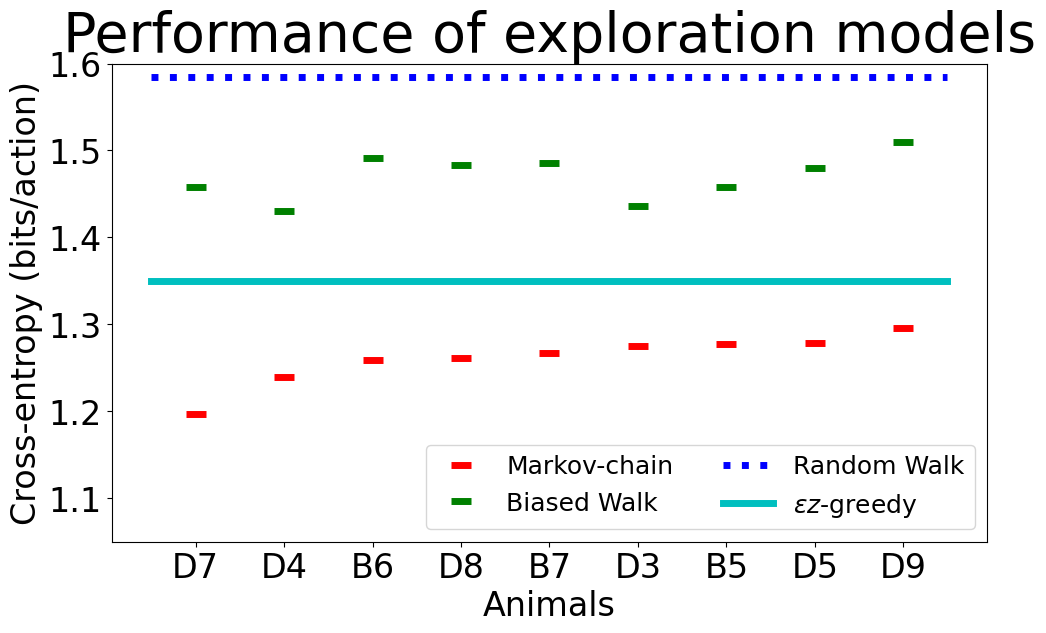

In [947]:
k=len(RewNames)
RN=np.array(RewNames)
UN=np.array(UnrewNamesSub)
ev=np.array(ev);ef=np.array(ef);eb=np.array(eb);en=np.array(en)
evu=ev[k:];efu=ef[k:];ebu=eb[k:];enu=en[k:]
siu=np.argsort(evu)
print('Limited to T-junctions during exploration, includes L vs R node pooling')

ax=plot(np.arange(len(UN)),[evu[siu],ebu[siu]],
    fmts=['r_','g_'],
        markersize=15,markeredgewidth=5,
     figsize=(10, 6));
plt.xlabel('Animals', fontsize=24)
plt.ylabel('Cross-entropy (bits/action)', fontsize=24)

plot([-0.5,len(UN)-0.5],[np.log(3)/np.log(2),np.log(3)/np.log(2)],
    fmts=['b:'],linewidth=5,ylim=[1.05,1.6],axes=ax);

plot([-0.5,len(UN)-0.5],[1.35, 1.35],
    fmts=['c-'],linewidth=5,ylim=[1.05,1.6],axes=ax);

plt.legend(['Markov-chain','Biased Walk','Random Walk', '$\epsilon z$-greedy'], loc='lower right', ncol=2, fontsize=18)
plt.xticks(np.arange(len(UN)), UN[siu], fontsize=24);
plt.yticks(fontsize=24);
plt.title('Performance of exploration models', fontsize=40)

plt.savefig(f'{figpath}/crossentropy.pdf', bbox_inches='tight')

In [1021]:
ebu, np.mean(ebu)

(array([1.45842527, 1.49084624, 1.48588955, 1.43664162, 1.43012857,
        1.47985568, 1.45851297, 1.48376734, 1.51014865]),
 1.4704684316703245)

B5
245 795
[3.6597938144329896] [1.442221767645142]


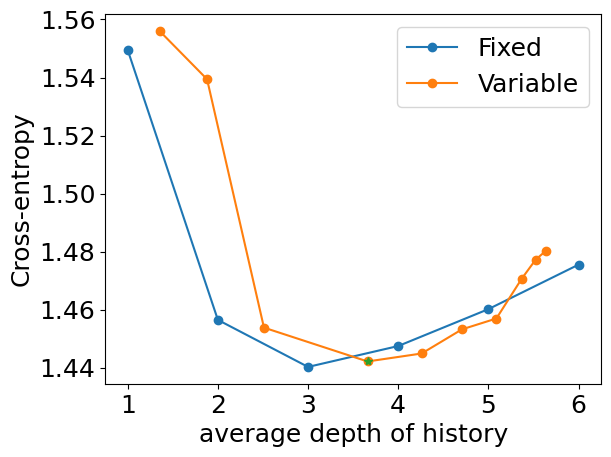

B6
223 795
[3.6597938144329896] [1.4979376583313344]


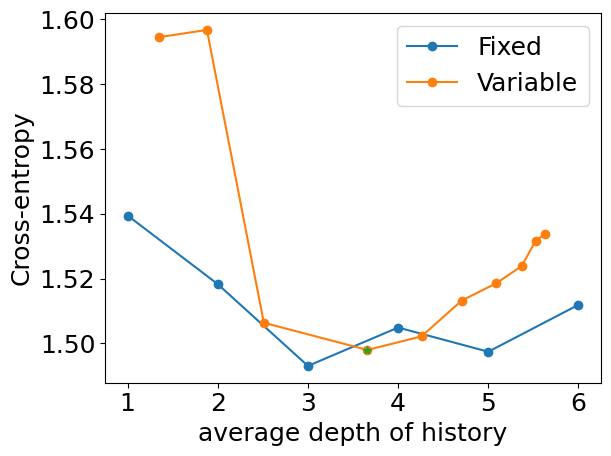

B7
204 795
[3.6597938144329896] [1.4694126736110777]


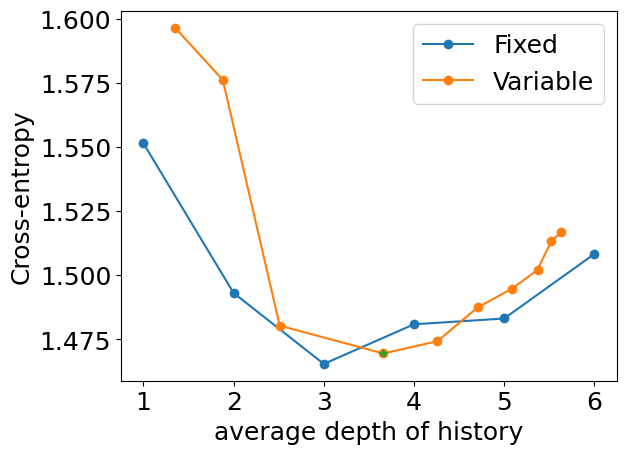

D3
245 795
[3.6597938144329896] [1.4173440895278555]


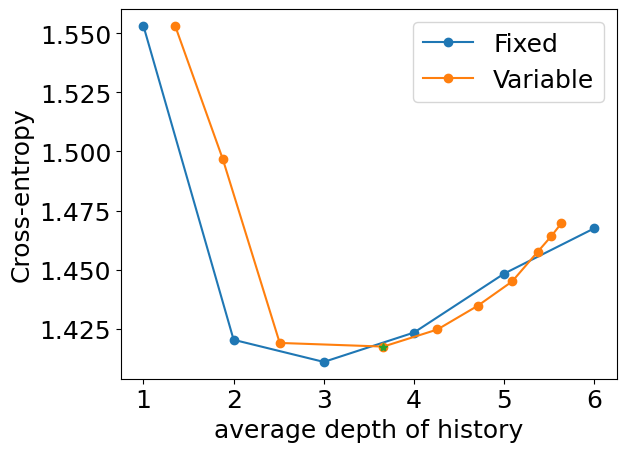

D4
319 795
[3.6597938144329896] [1.3969058109961634]


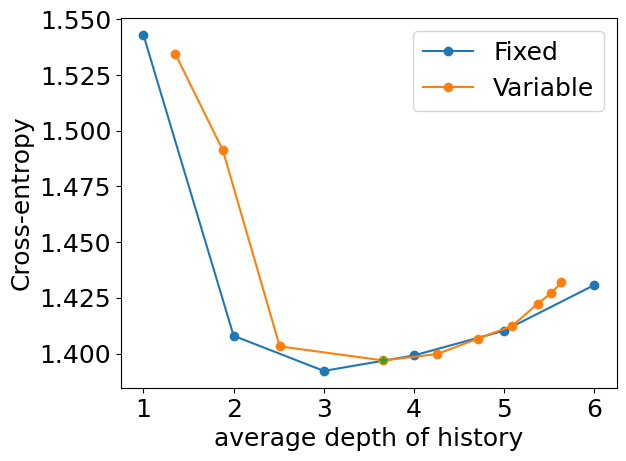

D5
180 795
[3.6597938144329896] [1.4564747878615245]


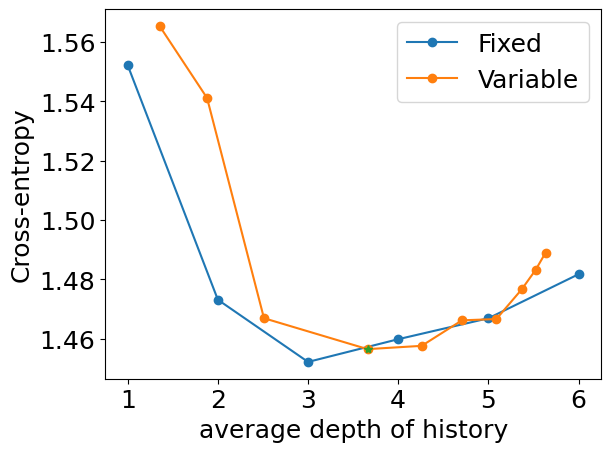

D7
150 795
[3.6597938144329896] [1.414249990051036]


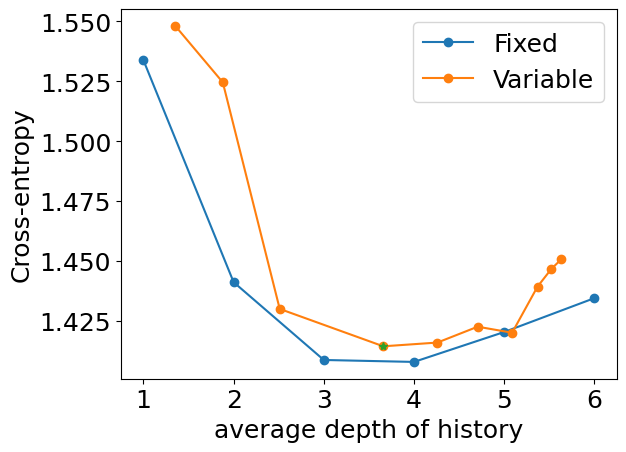

D8
109 795
[4.259668508287293] [1.469434760239697]


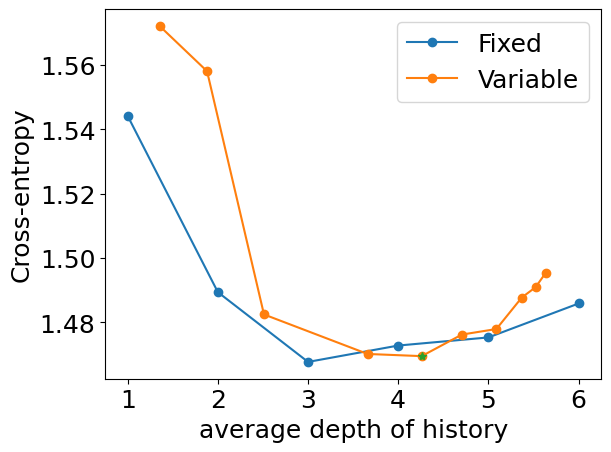

D9
102 795
[3.6597938144329896] [1.507362004119639]


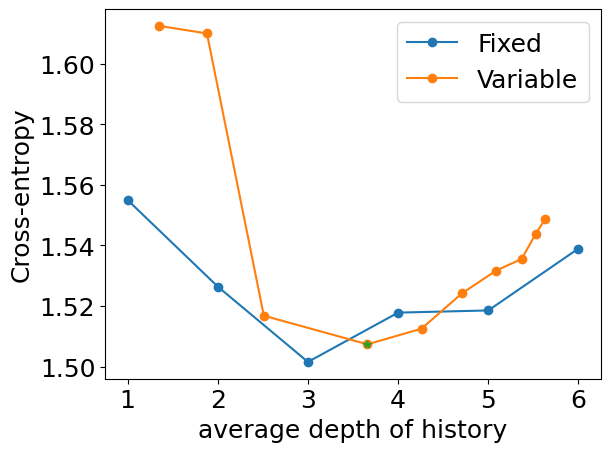

In [1022]:
ezu = []
for nickname in UnrewNamesSub:
    print(nickname)
    animal_tf = LoadTrajFromPath(f'../outdata/{nickname}-tf')
    ez_tf = ezgreedy_tfs[9]

    print(len(animal_tf.no), len(ez_tf.no))

    [hf5, hv5], [cf5, cv5] = em.markov_fit_test_pooling(ez_tf, animal_tf, re=False)

    plt.plot(hf5, cf5, '-o', label='Fixed')
    plt.plot(hv5, cv5, '-o', label='Variable')
    print([hv5[np.argmin(cv5)]], [cv5[np.argmin(cv5)]])
    plt.plot([hv5[np.argmin(cv5)]], [cv5[np.argmin(cv5)]], '*')
    ezu.append(cv5[np.argmin(cv5)])
    plt.ylabel('Cross-entropy')
    plt.xlabel('average depth of history')
    plt.legend(loc='upper right')
    plt.show()

In [1023]:
ebu, np.mean(ebu)

(array([1.45842527, 1.49084624, 1.48588955, 1.43664162, 1.43012857,
        1.47985568, 1.45851297, 1.48376734, 1.51014865]),
 1.4704684316703245)

In [1024]:
ezu, np.mean(ezu)

([1.442221767645142,
  1.4979376583313344,
  1.4694126736110777,
  1.4173440895278555,
  1.3969058109961634,
  1.4564747878615245,
  1.414249990051036,
  1.469434760239697,
  1.507362004119639],
 1.4523715047092745)

In [1030]:
(ebu-ezu)/ebu * 100

array([ 1.11102702, -0.47566428,  1.10888984,  1.3432393 ,  2.32306077,
        1.57994392,  3.03480193,  0.96595863,  0.18452818])

In [1032]:
(ebu-evu)/ebu * 100

array([12.38036474, 15.57016073, 14.69773998, 11.21886435, 13.33563725,
       13.58589905, 17.93956778, 15.02219064, 14.23091128])

In [1201]:
hez = []
cez = []
for i, tf in enumerate(ezgreedy_tfs):
    h, c = em.markov_fit_pooling_var_train_only(tf, re=False)
    print(i)
    hez.append(h)
    cez.append(c)

0
1
2
3
4
5
6
7
8
9
10


In [1176]:
hbw = []
cbw = []
for i, tf in enumerate(bw_tfs):
    h, c = em.markov_fit_pooling_var_train_only(tf, re=False)
    print(i)
    hbw.append(h)
    cbw.append(c)

0
1
2
3
4
5
6
7
8
9
10
11


In [1178]:
cbw

[array([1.49444593, 1.45339313, 1.43839956, 1.43665264, 1.44287186,
        1.4537607 , 1.46616353, 1.47616101, 1.48510957, 1.48930745]),
 array([1.49444593, 1.45339313, 1.43839956, 1.43665264, 1.44287186,
        1.4537607 , 1.46616353, 1.47616101, 1.48510957, 1.48930745]),
 array([1.49444593, 1.45339313, 1.43839956, 1.43665264, 1.44287186,
        1.4537607 , 1.46616353, 1.47616101, 1.48510957, 1.48930745]),
 array([1.49444593, 1.45339313, 1.43839956, 1.43665264, 1.44287186,
        1.4537607 , 1.46616353, 1.47616101, 1.48510957, 1.48930745]),
 array([1.49444593, 1.45339313, 1.43839956, 1.43665264, 1.44287186,
        1.4537607 , 1.46616353, 1.47616101, 1.48510957, 1.48930745]),
 array([1.49444593, 1.45339313, 1.43839956, 1.43665264, 1.44287186,
        1.4537607 , 1.46616353, 1.47616101, 1.48510957, 1.48930745]),
 array([1.49444593, 1.45339313, 1.43839956, 1.43665264, 1.44287186,
        1.4537607 , 1.46616353, 1.47616101, 1.48510957, 1.48930745]),
 array([1.49444593, 1.45339313, 1.

In [1117]:
hunc = []
cunc = []
for i, tf in enumerate(unc_tfs):
    h, c = em.markov_fit_pooling_var_train_only(tf, re=False)
    print(i)
    hunc.append(h)
    cunc.append(c)

0
1
2


In [1208]:
len(markov_tfs)

9

In [1242]:
import itertools

# Generate all permutations of elements 1 to 5
elements = range(len(markov_tfs))
permutations = list(itertools.permutations(elements))

# # Print the permutations
# for perm in permutations:
#     print(perm)
    
np.random.shuffle(permutations)

In [1243]:
permutations

[(7, 4, 5, 8, 3, 0, 6, 1, 2),
 (2, 7, 1, 6, 4, 0, 8, 5, 3),
 (5, 2, 3, 8, 7, 0, 6, 1, 4),
 (2, 7, 4, 8, 6, 0, 5, 3, 1),
 (8, 4, 6, 5, 1, 0, 2, 7, 3),
 (8, 6, 2, 7, 5, 3, 4, 0, 1),
 (5, 3, 1, 4, 8, 7, 0, 2, 6),
 (7, 0, 6, 3, 8, 1, 4, 5, 2),
 (4, 6, 0, 1, 7, 8, 5, 2, 3),
 (3, 1, 0, 7, 8, 2, 6, 5, 4),
 (4, 7, 5, 2, 8, 0, 3, 1, 6),
 (1, 8, 6, 2, 7, 5, 0, 4, 3),
 (3, 4, 0, 8, 7, 1, 2, 6, 5),
 (1, 2, 7, 0, 4, 5, 3, 8, 6),
 (4, 3, 5, 0, 2, 1, 8, 7, 6),
 (7, 4, 5, 0, 2, 1, 3, 6, 8),
 (5, 0, 8, 3, 7, 6, 4, 2, 1),
 (7, 3, 2, 4, 5, 0, 1, 6, 8),
 (3, 8, 0, 1, 5, 2, 6, 4, 7),
 (4, 8, 5, 6, 0, 7, 1, 3, 2),
 (4, 2, 5, 0, 8, 7, 1, 6, 3),
 (6, 1, 4, 3, 0, 2, 5, 8, 7),
 (7, 6, 0, 5, 8, 3, 2, 1, 4),
 (7, 2, 3, 8, 5, 4, 1, 6, 0),
 (0, 5, 6, 4, 8, 2, 3, 1, 7),
 (3, 0, 4, 1, 2, 7, 5, 8, 6),
 (8, 4, 0, 2, 6, 1, 5, 3, 7),
 (5, 1, 3, 6, 8, 4, 7, 2, 0),
 (0, 2, 3, 1, 4, 8, 5, 6, 7),
 (7, 6, 1, 4, 8, 5, 2, 3, 0),
 (0, 8, 2, 3, 7, 4, 5, 6, 1),
 (5, 7, 0, 4, 2, 3, 1, 6, 8),
 (7, 2, 5, 4, 3, 6, 0, 8, 1),
 (6, 7, 0,

In [1240]:
a=1

In [1277]:
hmarkov = []
cmarkov = []

for p in permutations[:10]:
    episodes = []
    for i in p[:5]:
        print(i)
        episodes.append(utils.wrap(markov_tfs[i].no[0][:, 0])[0][0][:5000])
    tf = convert_episodes_to_traj_class(episodes, episodes)
    h, c = em.markov_fit_pooling_var_train_only(tf, re=False)
    hmarkov.append(h)
    cmarkov.append(c)

7
4
5
8
3
MarkovFit3...
MarkovFit3 done...
2
7
1
6
4
MarkovFit3...
MarkovFit3 done...
5
2
3
8
7
MarkovFit3...
MarkovFit3 done...
2
7
4
8
6
MarkovFit3...
MarkovFit3 done...
8
4
6
5
1
MarkovFit3...
MarkovFit3 done...
8
6
2
7
5
MarkovFit3...
MarkovFit3 done...
5
3
1
4
8
MarkovFit3...
MarkovFit3 done...
7
0
6
3
8
MarkovFit3...
MarkovFit3 done...
4
6
0
1
7
MarkovFit3...
MarkovFit3 done...
3
1
0
7
8
MarkovFit3...
MarkovFit3 done...


In [1278]:
hmarkov

[array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.]),
 array([1., 2., 3., 4., 5., 6.])]

In [1279]:
cmarkov

[array([1.53838743, 1.36512364, 1.32028727, 1.28145741, 1.25424705,
        1.21783068]),
 array([1.51808589, 1.35127067, 1.28298144, 1.24514242, 1.21075217,
        1.1780854 ]),
 array([1.53739967, 1.37302839, 1.32572211, 1.28354777, 1.25367491,
        1.21621093]),
 array([1.52786266, 1.36075713, 1.3065154 , 1.26572596, 1.23068288,
        1.19714917]),
 array([1.52769919, 1.35525527, 1.29443692, 1.25161323, 1.22476326,
        1.19065967]),
 array([1.52826457, 1.36358459, 1.29921372, 1.25887602, 1.22696499,
        1.1900072 ]),
 array([1.53262645, 1.35586171, 1.30672035, 1.26968375, 1.2441218 ,
        1.20715782]),
 array([1.53053631, 1.35924116, 1.30783467, 1.26719153, 1.23588452,
        1.20023764]),
 array([1.51668716, 1.35130093, 1.28830315, 1.24865357, 1.21927697,
        1.18692435]),
 array([1.53067492, 1.37910222, 1.33180459, 1.29145159, 1.25826499,
        1.22293972])]

In [1247]:
np.min(cmarkov, axis=1)

array([1.26221414, 1.26063665, 1.26003764, 1.2642482 , 1.26252867,
       1.26216949, 1.26258857, 1.26206036, 1.2608418 , 1.26233491])

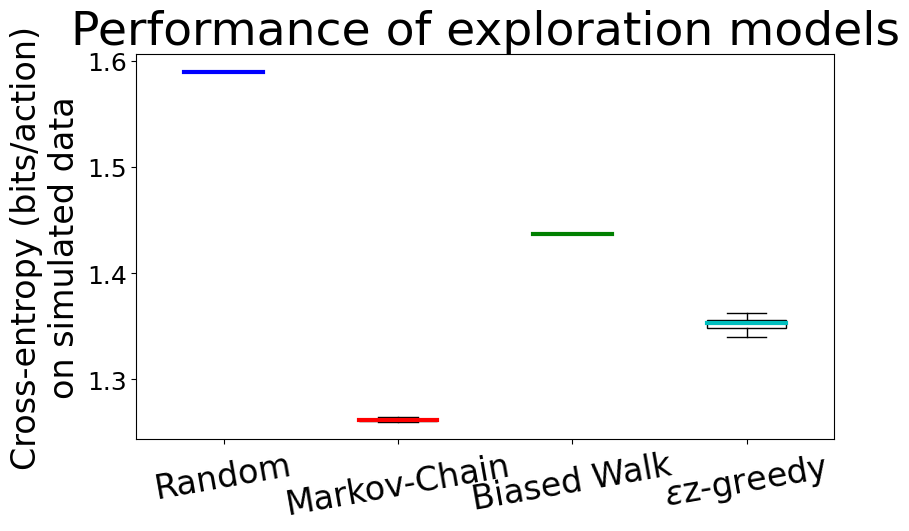

In [1256]:
plt.figure(figsize=(9, 5))

colors = 'brgc'
ce_models = {
    'Random': 1.59,
    'Markov-Chain': np.min(cmarkov, axis=1),
    'Biased Walk': np.min(cbw, axis=1),
    '$\epsilon$z-greedy': np.min(cez, axis=1),
}

box_plot = plt.boxplot(list(ce_models.values()), patch_artist=True, boxprops={'facecolor': 'white'}, medianprops={'linewidth':3})
for median, c in zip(box_plot['medians'], colors):
    median.set_color(c)

plt.ylabel('Cross-entropy (bits/action)\non simulated data', fontsize=24)
plt.title('Performance of exploration models', fontsize=34)

plt.xticks(range(1, len(ce_models)+1), list(ce_models.keys()), rotation=10, fontsize=24)

plt.savefig(f'{figpath}/crossentropyboxplot_poster.pdf', bbox_inches='tight')
plt.show()

In [1198]:
hbw = np.array(hbw)
hbw[range(hbw.shape[0]), np.argmin(cbw, axis=1)]

array([3.39515312, 3.39515312, 3.39515312, 3.39515312, 3.39515312,
       3.39515312, 3.39515312, 3.39515312, 3.39515312, 3.39515312,
       3.39515312, 3.39515312])

In [1204]:
np.mean(hbw[range(hbw.shape[0]), np.argmin(cbw, axis=1)])

3.3951531174267457

In [1202]:
hez = np.array(hez)
hez[range(hez.shape[0]), np.argmin(cez, axis=1)]

array([3.98206045, 3.93544886, 3.04830918, 3.98472581, 5.16635763,
       3.99757026, 4.00226092, 3.95863689, 2.99436204, 3.92753326,
       3.97157623])

In [1205]:
np.mean(hez[range(hez.shape[0]), np.argmin(cez, axis=1)])

3.9062583216177504

In [1268]:
hmarkov = np.array(hmarkov)
hmarkov[range(hmarkov.shape[0]), np.argmin(cmarkov, axis=1)]

array([5.37126381, 5.41000509, 5.45218297, 5.38611134, 5.39577695,
       5.41443258, 5.43871114, 5.36998793, 5.37885793, 5.4289305 ])

In [1269]:
np.mean(hmarkov[range(hmarkov.shape[0]), np.argmin(cmarkov, axis=1)])

5.40462602377254

In [1270]:
hmarkov

array([[1.17647059, 1.61647059, 2.28883721, 2.81379687, 3.6006006 ,
        4.28148148, 4.84625345, 5.14490067, 5.276311  , 5.37126381],
       [1.28571429, 1.61647059, 2.17170732, 2.82926829, 3.48596353,
        4.36003985, 4.9024531 , 5.15461861, 5.32479291, 5.41000509],
       [1.28571429, 1.72571429, 2.1955211 , 2.90074149, 3.57080176,
        4.33715568, 4.85059218, 5.19777294, 5.35894526, 5.45218297],
       [1.28571429, 1.61647059, 2.17170732, 2.90619137, 3.50229936,
        4.35626911, 4.89145074, 5.16101404, 5.30725845, 5.38611134],
       [1.17647059, 1.61647059, 2.21906977, 2.7988715 , 3.48484848,
        4.38532695, 4.83984954, 5.14196444, 5.2942345 , 5.39577695],
       [1.17647059, 1.54      , 2.14863498, 2.75641026, 3.49924086,
        4.21242292, 4.93276766, 5.1886935 , 5.33806139, 5.41443258],
       [1.17647059, 1.67684211, 2.1955211 , 2.75636766, 3.65333176,
        4.19205569, 4.90176533, 5.18426745, 5.30919828, 5.43871114],
       [1.17647059, 1.61647059, 2.0757575

In [1262]:
cmarkov

[array([1.2738069 , 1.266784  , 1.26522349, 1.26419647, 1.26356692,
        1.26302939, 1.2626341 , 1.26233351, 1.26224279, 1.26221414]),
 array([1.27238882, 1.26502472, 1.26343483, 1.26248903, 1.261882  ,
        1.26144955, 1.26107339, 1.26082757, 1.26071   , 1.26063665]),
 array([1.27171133, 1.26455723, 1.2630819 , 1.26201438, 1.26134909,
        1.2607929 , 1.26041747, 1.26015995, 1.26008655, 1.26003764]),
 array([1.27641957, 1.26907708, 1.26742526, 1.26629912, 1.26563846,
        1.26503603, 1.26462216, 1.26434741, 1.26428537, 1.2642482 ]),
 array([1.27400902, 1.26721011, 1.26544605, 1.26444847, 1.263786  ,
        1.26332245, 1.26296103, 1.26272412, 1.26259396, 1.26252867]),
 array([1.27497467, 1.26718608, 1.26523203, 1.26403989, 1.26348782,
        1.26291964, 1.26254315, 1.26230394, 1.26219838, 1.26216949]),
 array([1.27427671, 1.26746683, 1.26550064, 1.26451801, 1.26387015,
        1.26331872, 1.26291138, 1.26269442, 1.26258884, 1.26258857]),
 array([1.27330567, 1.26653044, 1.

In [17]:
import pickle
from utils import convert_episodes_to_traj_class
import evaluation_metrics as em
import parameters as p

In [13]:
# Calculating KL-divergence between learned state-action probability distribution vs estimated from the data.


In [14]:
from scipy.stats import entropy
from scipy.special import kl_div, rel_entr, entr

Biased Walk: 3.672566371681416 (3, 3, 3, 3, 3, 13, 3) 369347 5214
ez-greedy: 3.6597938144329896 (3, 3, 3, 3, 3, 13, 3) 335122 5211
B5: 3.015873015873016 (3, 3, 3, 3, 3, 13, 3) 11247 3111
3111
0.13237570030886506 0.10213847506504647
0.18816911453384644 0.12302631834650299
B6: 3.1343283582089554 (3, 3, 3, 3, 3, 13, 3) 12234 3297
3297
0.13298682817502433 0.10031759304144937
0.1821281541506405 0.11700074752494866
B7: 2.872727272727273 (3, 3, 3, 3, 3, 13, 3) 7742 2757
2757
0.15111910521102612 0.12414080490180741
0.19472748009288218 0.1386642279735103
D3: 2.5531914893617023 (3, 3, 3, 3, 3, 13, 3) 8073 2877
2877
0.13413445383785255 0.11244004376882011
0.16337701004432653 0.11441375538840125
D4: 3.36 (3, 3, 3, 3, 3, 13, 3) 12828 3018
3018
0.13727619169740884 0.10823961829324277
0.1917985604763795 0.1305136066533253
D5: 3.4177215189873418 (3, 3, 3, 3, 3, 13, 3) 14283 3060
3060
0.1510011266817758 0.1135725520890856
0.2151314318975019 0.14031615382015541
D7: 3.267605633802817 (3, 3, 3, 3, 3, 13, 

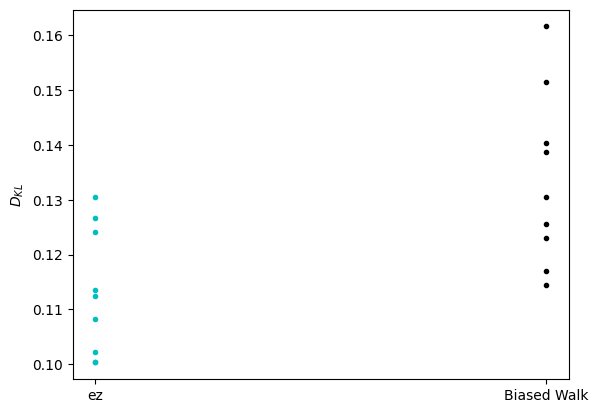

In [24]:
par = 50
var = True

with open("/Users/us3519/mouse-maze/figs/BiasedWalk4/simulations/episodes_many.pkl", 'rb') as f:
    s = pickle.load(f)
biasedwalk_tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
hi_bw, pr_bw, pt_bw, pt_dict_bw = em.markov_fit_pooling_pr(biasedwalk_tf, re=False, var=var, par=25*par)
print('Biased Walk:', hi_bw, pr_bw.shape, len(pt_bw), len(pt_dict_bw))

with open("/Users/us3519/mouse-maze/figs/LWISOptL6Alternate/simulations/episodes_many.pkl", 'rb') as f:
    s = pickle.load(f)
ezgreedy_tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
hi_ez, pr_ez, pt_ez, pt_dict_ez = em.markov_fit_pooling_pr(ezgreedy_tf, re=False, var=var, par=25*par)
print('ez-greedy:', hi_ez, pr_ez.shape, len(pt_ez), len(pt_dict_ez))

# hi_unc, pr_unc, pt_unc, pt_dict_unc = em.markov_fit_pooling_pr(bayesian_tf, re=False, var=var, par=par)
# print('Uncertainty:', hi_unc, pr_unc.shape, len(pt_unc), len(pt_dict_unc))

entr_animal_ezs = []
entr_animal_bws = []
for nickname in p.UnrewNamesSub:
    tf = LoadTrajFromPath(f'../outdata/{nickname}-tf')
    hi_animal, pr_animal, pt_animal, pt_dict_animal = em.markov_fit_pooling_pr(tf, re=False, var=var, par=par)
    print(f'{nickname}:', hi_animal, pr_animal.shape, len(pt_animal), len(pt_dict_animal))

    common_states = set(pt_dict_animal.keys()).intersection(set(pt_dict_ez.keys()))\
    .intersection(set(pt_dict_bw.keys()))#.intersection(set(pt_dict_unc.keys()))
    print(len(common_states))

    pt_animal_common = np.array([pt_dict_animal[_] for _ in common_states])
    pt_ez_common = np.array([pt_dict_ez[_] for _ in common_states])
    pt_bw_common = np.array([pt_dict_bw[_] for _ in common_states])
#     pt_unc_common = np.array([pt_dict_unc[_] for _ in common_states])

    pt_animal_common = pt_animal_common/np.sum(pt_animal_common)
    pt_ez_common = pt_ez_common/np.sum(pt_ez_common)
    pt_bw_common = pt_bw_common/np.sum(pt_bw_common)
#     pt_unc_common = pt_unc_common/np.sum(pt_unc_common)

    print(np.sum(rel_entr(pt_ez_common, pt_animal_common)), np.sum(rel_entr(pt_animal_common, pt_ez_common)))
    print(np.sum(rel_entr(pt_bw_common, pt_animal_common)), np.sum(rel_entr(pt_animal_common, pt_bw_common)))
#     print(np.sum(rel_entr(pt_unc_common, pt_animal_common)), np.sum(rel_entr(pt_animal_common, pt_unc_common)))

    entr_animal_ez = np.sum(rel_entr(pt_animal_common, pt_ez_common))
    entr_animal_bw = np.sum(rel_entr(pt_animal_common, pt_bw_common))
    
    entr_animal_ezs.append(entr_animal_ez)
    entr_animal_bws.append(entr_animal_bw)
#     break

plt.plot([1]*len(entr_animal_ezs), entr_animal_ezs, 'c.')
plt.plot([2]*len(entr_animal_bws), entr_animal_bws, 'k.')
plt.xticks([1, 2], ['ez', 'Biased Walk'])
plt.ylabel('$D_{KL}$')
plt.show()